In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import torch
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split

import sys
sys.path.append("../src")

from utils import rescale
from PaintingDataset import PaintingDataset
from visualization import plot_confusion_matrix

In [2]:
mps_is_ok = torch.backends.mps.is_built() and torch.backends.mps.is_available()
device = torch.device('mps' if mps_is_ok else 'cpu')
print(device)

mps


# Annotation

In [3]:
filename_ann = "../data/raw/annotation.csv"

ann = pd.read_csv(filename_ann)
ann.head()

,label,author,title,filename,width,height,label_code
0,rococo,franz-xaver-winterhalter,pincess-clothilde-von-saxen-coburg,franz-xaver-winterhalter_pincess-clothilde-von...,448,500,7
1,rococo,franz-xaver-winterhalter,anna-dollfus-baronness-de-bourgoing,franz-xaver-winterhalter_anna-dollfus-baronnes...,386,500,7
2,rococo,jean-baptiste-simeon-chardin,still-life-with-cat-and-rayfish,jean-baptiste-simeon-chardin_still-life-with-c...,398,500,7
3,rococo,william-hogarth,portrait-of-en-francis-dashwood-15th-baron-of-...,william-hogarth_portrait-of-en-francis-dashwoo...,370,500,7
4,rococo,franz-xaver-winterhalter,portrait-of-francisca-caroline-gonzaga-de-brag...,franz-xaver-winterhalter_portrait-of-francisca...,348,500,7


In [4]:
ann["label"].value_counts()

cubism           365
impressionism    240
naturalism       218
japonism         203
photo            139
rococo           117
cartoon           75
artdeco           65
Name: label, dtype: int64

In [5]:
code2label = ann[["label", "label_code"]].drop_duplicates().set_index("label_code")["label"]
code2label.sort_index(inplace=True)
code2label

label_code
0          artdeco
1          cartoon
2           cubism
3    impressionism
4         japonism
5       naturalism
6            photo
7           rococo
Name: label, dtype: object

In [6]:
n_classes = len(ann.label.unique())
print(n_classes)

8


In [7]:
ann.groupby("label")["author"].apply(lambda x: len(x.unique()))

label
artdeco           11
cartoon            1
cubism            85
impressionism    102
japonism          29
naturalism        11
photo              1
rococo            23
Name: author, dtype: int64

# Train-test split

1. Случайное разбиение самих картин
2. Разбиение по авторам. Так делать правильнее, потому что стили авторов запоминаются.

In [8]:
indices_train, indices_test = train_test_split(ann.index, test_size=0.25, random_state=42, stratify=ann.label)
ann["fold_random"] = "train"
ann.loc[indices_test, "fold_random"] = "test"

ann.groupby("label")["fold_random"].value_counts()

label          fold_random
artdeco        train           49
               test            16
cartoon        train           56
               test            19
cubism         train          274
               test            91
impressionism  train          180
               test            60
japonism       train          152
               test            51
naturalism     train          163
               test            55
photo          train          104
               test            35
rococo         train           88
               test            29
Name: fold_random, dtype: int64

## 2. author split

In [9]:
test_size = 0.25
ann["fold_author"] = ann["fold_random"].copy()

for label in ann.label.unique():

    mask_label = ann.label == label

    authors = ann.loc[mask_label, "author"]

    if authors.isna().all():
        print(f"label -- x")
        continue

    n_images = len(authors)
    n_images_test = int(test_size * n_images)

    authors_counts = authors.value_counts()
    
    error = 100
    error_max = 0.05  

    while error > error_max:

        # shuffle rows
        authors_counts = authors_counts.sample(frac=1)
        
        authors_counts = authors_counts.cumsum()

        authors_test = authors_counts[authors_counts < n_images_test].index

        test_size_current = len(authors_test) / len(authors.unique())
        error = np.abs(test_size_current - test_size)

    print(f"{label} -- {test_size_current:.2f}")

    ann.loc[mask_label, "fold_author"] = "train"
    ann.loc[mask_label & ann.author.isin(authors_test), "fold_author"] = "test"

rococo -- 0.26
japonism -- 0.28
label -- x
cubism -- 0.21
impressionism -- 0.29
naturalism -- 0.27
label -- x
artdeco -- 0.27


In [10]:
ann

,label,author,title,filename,width,height,label_code,fold_random,fold_author
0,rococo,franz-xaver-winterhalter,pincess-clothilde-von-saxen-coburg,franz-xaver-winterhalter_pincess-clothilde-von...,448,500,7,train,train
1,rococo,franz-xaver-winterhalter,anna-dollfus-baronness-de-bourgoing,franz-xaver-winterhalter_anna-dollfus-baronnes...,386,500,7,train,train
2,rococo,jean-baptiste-simeon-chardin,still-life-with-cat-and-rayfish,jean-baptiste-simeon-chardin_still-life-with-c...,398,500,7,train,train
3,rococo,william-hogarth,portrait-of-en-francis-dashwood-15th-baron-of-...,william-hogarth_portrait-of-en-francis-dashwoo...,370,500,7,test,train
4,rococo,franz-xaver-winterhalter,portrait-of-francisca-caroline-gonzaga-de-brag...,franz-xaver-winterhalter_portrait-of-francisca...,348,500,7,train,train
...,...,...,...,...,...,...,...,...,...
1417,artdeco,john-vassos,abstract-design-1972,john-vassos_abstract-design-1972.jpg,498,500,0,train,test
1418,artdeco,john-vassos,abstract-sailboat,john-vassos_abstract-sailboat.jpg,500,500,0,train,test
1419,artdeco,erte,splendeur,erte_splendeur.jpg,387,500,0,train,test
1420,artdeco,tamara-de-lempicka,bowl-of-grapes-1949,tamara-de-lempicka_bowl-of-grapes-1949.jpg,361,361,0,train,train


In [11]:
# ann.to_csv("../data/raw/annotation-folds.csv", index=False)

In [12]:
ann = pd.read_csv("../data/raw/annotation-folds.csv")

# ResNet18

In [13]:
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from torchvision import transforms

# Transformations

In [14]:
transform_resnet = ResNet18_Weights.DEFAULT.transforms()

In [15]:
transform_train = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.),
    transforms.RandomErasing(p=0.5),
    transform_resnet
])

# Dataset

In [40]:
folder_images = "../data/raw/images"

mask_test = ann.fold_author == "test"

dataset_test = PaintingDataset(
    ann[mask_test],
    folder_images,
    transform_preprocess=transform_resnet
)

dataset_train = PaintingDataset(
    ann[~mask_test],
    folder_images,
    transform_train=transform_train
)

100%|██████████| 961/961 [00:01<00:00, 497.52it/s]


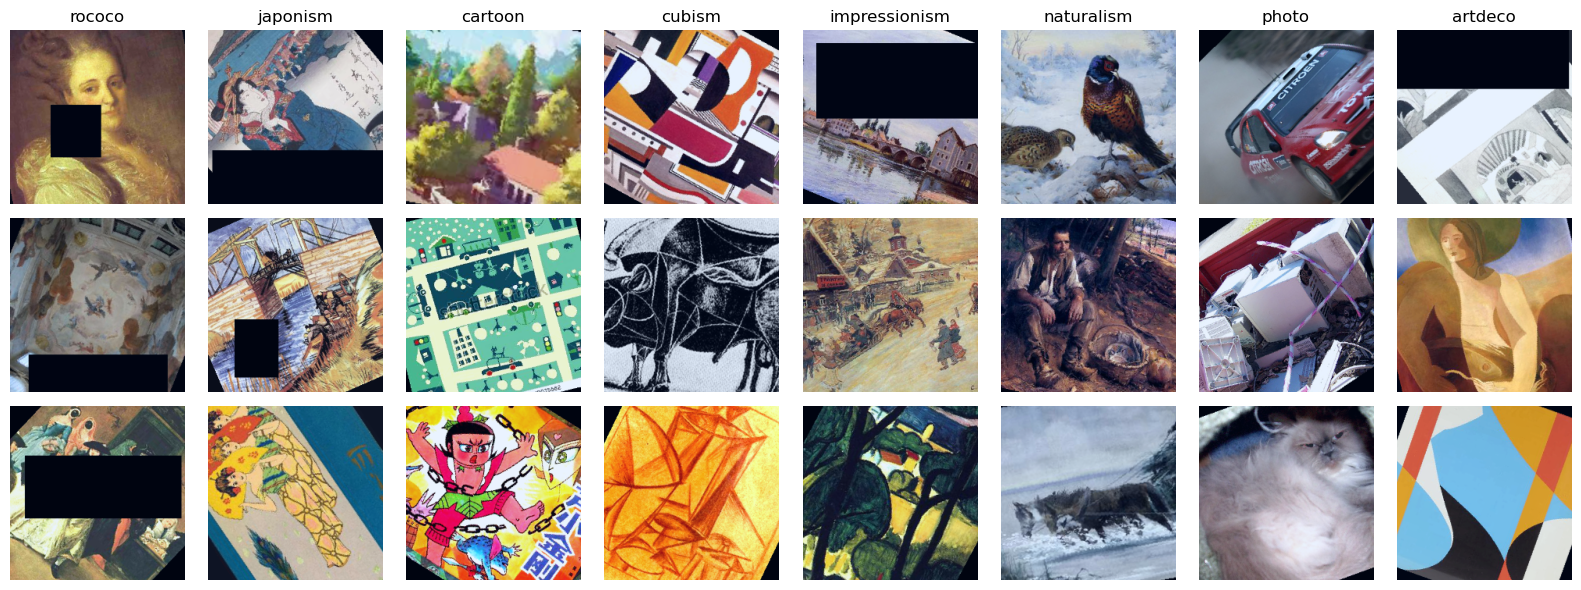

In [41]:
nrows = 3
ncols = n_classes
scale = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows * scale), dpi=100)

dataset = dataset_train

for axes_col, label in zip(axes.T, dataset.ann.label.unique()):

    indices_label = np.where(np.asarray(dataset.labels) == label)[0]
    indices = np.random.choice(indices_label, nrows)

    for i, ax in zip(indices, axes_col):
        x, _ = dataset[i]

        plt.sca(ax)

        plt.imshow(rescale(x.permute(1, 2, 0)))

        if ax.get_subplotspec().is_first_row():
            plt.title(label)

        plt.xticks([])
        plt.yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()

# Dataloader

In [42]:
batch_size = 128

dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
dataloader_train = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Train

In [43]:
from sklearn.metrics import f1_score

def calculate_score(y_true, y_pred):
    y_true = y_true.cpu().detach().argmax(dim=1).numpy()
    y_pred = y_pred.cpu().detach().argmax(dim=1).numpy()
    score = f1_score(y_true, y_pred, average="micro")
    return score

In [44]:
def test_model(model, dataloader, criterion):

    model.eval()

    y_true_list = []
    y_pred_list = []

    with torch.no_grad():

        for X, y_true in dataloader:
            X = X.to(device)
            y_true = y_true.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y_true)

            y_true_list.append(y_true)
            y_pred_list.append(y_pred)

    y_true_list = torch.vstack(y_true_list)
    y_pred_list = torch.vstack(y_pred_list)

    loss = criterion(y_pred_list, y_true_list).item()
    score = calculate_score(y_pred_list, y_true_list)

    return loss, score


def train_model(model, dataloader, criterion, optimizer):

    y_true_list = []
    y_pred_list = []

    model.train()

    for X, y_true in dataloader:
        X = X.to(device)
        y_true = y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(X)

        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        y_true_list.append(y_true)
        y_pred_list.append(y_pred)

    y_true_list = torch.vstack(y_true_list)
    y_pred_list = torch.vstack(y_pred_list)

    model.eval()

    loss = criterion(y_pred_list, y_true_list).item()
    score = calculate_score(y_pred_list, y_true_list)

    return loss, score


def train_epoch(model, optimizer, criterion, train_dataloader, test_dataloader):

    objectives = {}

    loss, score = train_model(model, train_dataloader, criterion, optimizer)
    objectives["loss_train"] = loss
    objectives["score_train"] = score

    loss, score = test_model(model, test_dataloader, criterion)
    objectives["loss_test"] = loss
    objectives["score_test"] = score

    return objectives

In [21]:
import os

def train(model, optimizer, criterion, train_dataloader, test_dataloader, params):

    folder_output_model = params["folder_output_model"]
    os.makedirs(folder_output_model, exist_ok=True)

    filename_save_model_st = os.path.join(folder_output_model, "model.st")
    filename_save_model_pt = os.path.join(folder_output_model, "model.pt")

    folder_output_progress = params["folder_output_report"]
    os.makedirs(folder_output_progress, exist_ok=True)

    filename_save_progress = os.path.join(folder_output_progress, f"progress.csv")

    score_test_best = 0.0

    rows = []
    n_epochs = params["n_epochs"]

    # mlflow.log_param("n_epochs", n_epochs)

    with trange(n_epochs) as t:
        for epoch in t:

            objectives = train_epoch(
                model, optimizer, criterion, train_dataloader, test_dataloader
            )
            rows.append(objectives)

            # mlflow.log_metrics(objectives, step=epoch)

            score_test = objectives["score_test"]
            if score_test > score_test_best:
                score_test_best = score_test

                torch.save(model.state_dict(), filename_save_model_st)
                # mlflow.log_artifact(filename_save_model_st)

                model_scripted = torch.jit.script(model)
                model_scripted.save(filename_save_model_pt)
                # mlflow.log_artifact(filename_save_model_pt)

            t.set_postfix(
                train=objectives["score_train"], test=score_test, best=score_test_best
            )

            df_progress = pd.DataFrame(rows)
            df_progress.index.name = "epochs"
            df_progress.to_csv(filename_save_progress, index=False)

    return df_progress

# Go

In [45]:
device = torch.device("mps")

In [46]:
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False

head = nn.Sequential(
    nn.Linear(resnet.fc.out_features, n_classes)
)

model = nn.Sequential(
    resnet,
    head
)

model = model.to("cpu");

summary(model, (3, 224, 224), batch_size=batch_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]          36,864
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
       BasicBlock-11          [128, 64, 56, 56]               0
           Conv2d-12          [128, 64, 56, 56]          36,864
      BatchNorm2d-13          [128, 64, 56, 56]             128
             ReLU-14          [128, 64,

In [47]:
model = model.to(device)

In [48]:
label_weight = 1 / dataset_train.ann.label_code.value_counts(normalize=True).sort_index()
label_weight

0    35.592593
1    17.160714
2     3.395760
3     5.309392
4    10.333333
5     6.082278
6     9.240385
7    16.288136
Name: label_code, dtype: float64

In [49]:
label_smoothing = 0.1
criterion = nn.CrossEntropyLoss(
    label_smoothing=label_smoothing,
    weight=torch.tensor(label_weight).float().to(device)
)

optimizer = torch.optim.Adam(head.parameters(), lr=1e-3)

In [50]:
params = {
    "folder_output_model": "../models/resnet18-transfer",
    "folder_output_report": "../reports/resnet18-transfer",
    "n_epochs": 100
}

In [51]:
x, y = next(iter(dataloader_train))
x = x.to(device)

y_pred = model(x)

In [52]:
df_progress = train(
    model,
    optimizer,
    criterion,
    dataloader_train,
    dataloader_test,
    params
)

100%|██████████| 100/100 [03:08<00:00,  1.88s/it, best=0.92, test=0.92, train=0.957] 


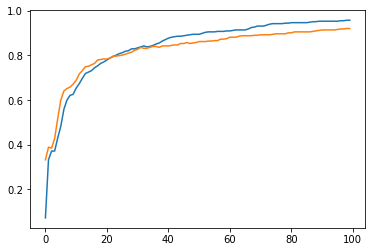

In [53]:
plt.plot(df_progress["score_train"])
plt.plot(df_progress["score_test"])
plt.show()

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
def create_report(model, dataloader):

    model.eval()

    y_true_list = []
    y_pred_list = []

    with torch.no_grad():

        for X, y_true in dataloader:
            X = X.to(device)
            y_true = y_true.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y_true)

            y_true_list.append(y_true)
            y_pred_list.append(y_pred)

    y_true_list = torch.vstack(y_true_list)
    y_pred_list = torch.vstack(y_pred_list)

    y_true = y_true_list.cpu().detach().argmax(dim=1).numpy()
    y_pred = y_pred_list.cpu().detach().argmax(dim=1).numpy()

    return y_true, y_pred

               precision    recall  f1-score   support

      artdeco       0.64      1.00      0.78        38
      cartoon       1.00      1.00      1.00        19
       cubism       0.99      0.84      0.91        82
impressionism       0.96      0.78      0.86        59
     japonism       0.94      0.92      0.93       110
   naturalism       1.00      0.97      0.98        60
        photo       1.00      1.00      1.00        35
       rococo       0.89      1.00      0.94        58

     accuracy                           0.92       461
    macro avg       0.93      0.94      0.93       461
 weighted avg       0.94      0.92      0.92       461



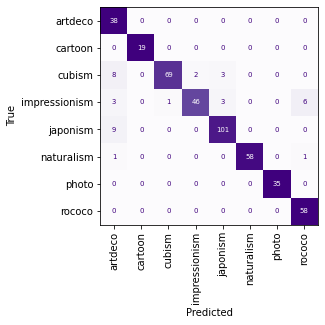

In [56]:
y_true, y_pred = create_report(model, dataloader_test)
report = classification_report(y_true, y_pred, target_names=code2label)
print(report)

confmat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(
    confmat,
    labels=code2label,
    xticks_rotation="vertical",
    cmap="Purples",
    normalize_plot="true"
);


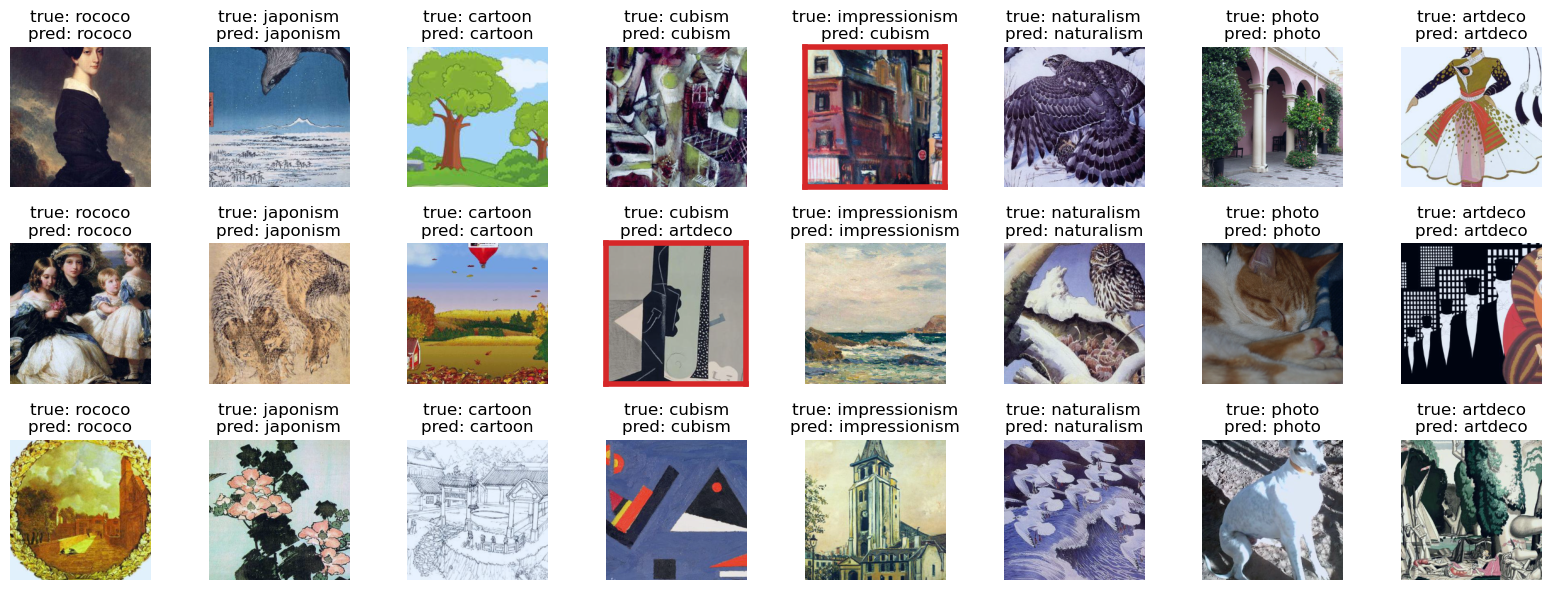

In [57]:
nrows = 3
ncols = n_classes
scale = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows * scale), dpi=100)

dataset = dataset_test

for axes_col, label in zip(axes.T, dataset.ann.label.unique()):

    indices_label = np.where(np.asarray(dataset.labels) == label)[0]
    indices = np.random.choice(indices_label, nrows, replace=False)

    for i, ax in zip(indices, axes_col):
        x, _ = dataset[i]
        x = x.to(device)

        y_pred = model(x.unsqueeze(0)).squeeze().argmax().item()
        label_pred = code2label[y_pred]

        plt.sca(ax)

        plt.imshow(rescale(x.cpu().permute(1, 2, 0)))

        title = f"true: {label}\npred: {label_pred}"
        plt.title(title)

        is_correct = label == label_pred

        plt.xticks([])
        plt.yticks([])

        for spine in ax.spines.values():
            if is_correct:
                spine.set_visible(False)
            else:
                spine.set_edgecolor("C3")
                spine.set_linewidth(4)

plt.tight_layout()